# Оценка длительностей и количества раундов инвентаризации

В этом эксперименте найдем оценки длительностей раундов инвентаризации и их 
числа за время нахождения метки в области действия счиытвателя.

## Настройка ноутбука

In [1]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [114]:
import os

import locale

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches

from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import product
from collections import namedtuple
from copy import deepcopy
import time
import numpy as np
import pandas as pd
from typing import Sequence, Tuple, Optional, Union, Iterable

# Подключаем локальные пакеты
import pyons
from pyons.models.rfid import protocol as gen2
from pyons.models.rfid.protocol import TagFrame, ReaderFrame, TagEncoding, \
    DR, InventoryFlag as Flag

In [94]:
# Настраиваем matplotlib
%matplotlib inline
CMAP_NAME = 'inferno'  # Цветовая схема для графиков

matplotlib.rcParams.update({
    'image.cmap': CMAP_NAME,
    'axes.formatter.use_locale': True,
    'font.size': 16,
    'font.family': 'sans-serif',
    
    # Шрифт PT Serif Caption можно установить с Google Fonts.
    # После установки шрифта нужно удалить кэш matplitlib,
    # на Ubuntu: ~/.cache/matplotlib 
    'font.sans-serif': ['PT Serif Caption',],
})

locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')

'ru_RU.UTF-8'

Введем вспомогательные функции для сохранения изображений и конвертации единиц.

In [95]:
IMAGE_BASE_DIR = "images"  # Здесь будут храниться все построенные изображения


def get_color(x):
    """
    Получить цвет из текущей карты.
    """
    return cm.get_cmap(CMAP_NAME)(x)


def savefig(out: Union[str, Sequence[str]] = ()):
    if out:
        if isinstance(out, str):
            out = (out,)
        for file_name in out:
            file_path = os.path.join(IMAGE_BASE_DIR, file_name)
            plt.savefig(file_path, bbox_inches="tight")

            
def kmph2mps(x: float) -> float:
    """Перевести км/ч в м/с"""
    return x * 5 / 18


def random_hex_string(bs: int) -> str:
    return "".join([f"{np.random.randint(0, 256):02X}" for _ in range(bs)])

## Параметры окружения

Зададим общие параметры, которые будут использоваться в расчетах по-умолчанию.

In [96]:
TARI_US = [6.25, 12.5, 18.75, 25]
M = [gen2.TagEncoding.FM0, gen2.TagEncoding.M2, 
     gen2.TagEncoding.M4, gen2.TagEncoding.M8]
DRS = [gen2.DR.DR_8, gen2.DR.DR_643]
L = 9             # длина области, где есть связь между считывателем и меткой
V = 60            # скорость автомобиля, км/ч
RTCAL_MUL = 2.25  # во сколько раз RTcal больше Tari
TRCAL_MUL = 1.95  # во сколько раз TRcal больше RTcal
EPC_SIZE = 12     # длина EPCID в байтах
TID_SIZE = 8      # длина TID в байтах

EPC = random_hex_string(EPC_SIZE)
TID = random_hex_string(TID_SIZE)

print("I will use these constants:")
print(f"- EPC: {EPC} ({EPC_SIZE} bytes)")
print(f"- TID: {TID} ({TID_SIZE} bytes)")

I will use these constants:
- EPC: D77F090880433293E9D6620D (12 bytes)
- TID: F56E46258B6C3729 (8 bytes)


## Расчет длительностей команд и ответов

Для начала определим, как будут меняться длительность команд считывателя и ответов метки в зависимости от настроек протокола.

Будем рассматривать длительности сообщений:

- команд `Query`, `QueryRep`, `Ack`, `Req_RN`, `Read`
- ответов `RN16`, `EPC+PC+CRC`, `Handle`, `Data`

Зависимости будем проверять от:

- `DR` (и команды, и ответы)
- `Tari` (и команды, и ответы)
- `TRExt` (только ответы)
- `M` (ответы)

Длительности символов `data-1`, `RTcal` и `TRcal` определяются через множители `Tari`. Согласно стандарту (c. 29):

- `2.5 Tari <= RTcal <= 3.0 Tari`
- `1.1 RTcal <= TRcal <= 3.0 RTcal`

При расчете будем ориентироваться на средние значения коэффициентов, то есть будем полагать, что:

- `RTcal = 2.25 Tari`
- `TRcal = 1.95 RTcal`

Длительность `RTcal` равна суммарной длительности `data-0 = Tari` и `data-1`.

Кроме длительностей команд и ответов вычислим величину `BLF = DR / TRcal` и скорость в канале от метки к считывателю, равную `BLF / M`.

> Для удобства, все длительности будем хранить в **микросекундах**, BLF - в **КГц**, а bitrate - в **кбит/c**.

In [184]:
def build_messages_df():
    rows = []
    for tari_us, m, dr, trext in product(TARI_US, M, DRS, (False, True)):
        tari = tari_us * 1e-6
        rtcal = RTCAL_MUL * tari
        trcal = TRCAL_MUL * rtcal
        blf = dr.ratio / trcal
        bitrate = blf / m.value
        
        # Строим команды
        # --------------
        preamble = gen2.ReaderFrame.Preamble(tari, rtcal, trcal)
        sync = gen2.ReaderFrame.Sync(tari, rtcal)
        
        query = gen2.Query(dr=dr, m=m, trext=trext, sel=gen2.Sel.SL_ALL, 
                           session=gen2.Session.S0, target=gen2.InventoryFlag.A, 
                           q=4, crc5=0x15)
        query_rep = gen2.QueryRep(session=gen2.Session.S0)
        ack = gen2.Ack(0x5555)
        req_rn = gen2.ReqRn(0x5555, 0x5555)
        read = gen2.Read(gen2.Bank.TID, 0, 4, rn=0x5555, crc16=0x5555)
        
        # Строим ответы
        # -------------
        rn16 = gen2.Rn16Reply(0x5555)
        epc_pc = gen2.AckReply(EPC)
        handle = gen2.ReqRnReply(0)
        data = gen2.ReadReply([0xABAB] * (TID_SIZE//2), 0, 0)
        
        rows.append({
            'Tari': tari_us,            
            'TRcal': trcal * 1_000_000,
            'M': m,
            'DR': dr,
            'BLF': blf / 1_000,
            'TRext': trext,
            'Bitrate': bitrate / 1_000,
            'Query': ReaderFrame(preamble, query).duration * 1_000_000,
            'QueryRep': ReaderFrame(sync, query_rep).duration * 1_000_000,
            'Ack': ReaderFrame(sync, ack).duration * 1_000_000,
            'Req_RN': ReaderFrame(sync, req_rn).duration * 1_000_000,
            'Read': ReaderFrame(sync, read).duration * 1_000_000,
            'RN16': TagFrame(m, trext, blf, rn16).duration * 1_000_000,
            'EPC+PC+CRC': TagFrame(m, trext, blf, epc_pc).duration * 1_000_000,
            'Handle': TagFrame(m, trext, blf, handle).duration * 1_000_000,
            'Data': TagFrame(m, trext, blf, data).duration * 1_000_000,
        })
    df = pd.DataFrame(rows)
    return df

DF = build_messages_df()
DF

,Tari,TRcal,M,DR,BLF,TRext,Bitrate,Query,QueryRep,Ack,Req_RN,Read,RN16,EPC+PC+CRC,Handle,Data
0,6.25,27.421875,TagEncoding.FM0,DR.DR_8,291.737892,False,291.737892,205.546875,57.8125,159.375,312.5,428.125,78.837891,462.744141,133.681641,356.484375
1,6.25,27.421875,TagEncoding.FM0,DR.DR_8,291.737892,True,291.737892,207.109375,57.8125,159.375,312.5,428.125,119.970703,503.876953,174.814453,397.617187
2,6.25,27.421875,TagEncoding.FM0,DR.DR_643,777.967711,False,777.967711,207.109375,57.8125,159.375,312.5,428.125,29.564209,173.529053,50.130615,133.681641
3,6.25,27.421875,TagEncoding.FM0,DR.DR_643,777.967711,True,777.967711,208.671875,57.8125,159.375,312.5,428.125,44.989014,188.953857,65.555420,149.106445
4,6.25,27.421875,TagEncoding.M2,DR.DR_8,291.737892,False,145.868946,207.109375,57.8125,159.375,312.5,428.125,185.097656,952.910156,294.785156,740.390625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,25.00,109.687500,TagEncoding.M4,DR.DR_643,194.491928,True,48.622982,803.437500,193.7500,600.000,1212.5,1675.000,802.089844,3105.527344,1131.152344,2467.968750
60,25.00,109.687500,TagEncoding.M8,DR.DR_8,72.934473,False,9.116809,797.187500,193.7500,600.000,1212.5,1675.000,2961.562500,15246.562500,4716.562500,11846.250000
61,25.00,109.687500,TagEncoding.M8,DR.DR_8,72.934473,True,9.116809,803.437500,193.7500,600.000,1212.5,1675.000,4277.812500,16562.812500,6032.812500,13162.500000
62,25.00,109.687500,TagEncoding.M8,DR.DR_643,194.491928,False,24.311491,803.437500,193.7500,600.000,1212.5,1675.000,1110.585938,5717.460938,1768.710937,4442.343750


In [185]:
def set_axes_formatter(*axes, use_x=False, use_y=False):
    """
    У некоторых нормальных шрифтов нет глифов, которые нужны
    в русской локали. Поэтому стараемся избежать ситуации,
    когда эти глифы нужны.
    
    Сейчас обходим глиф-пробел 8239 в формате больших целых.
    """
    def fmt(value, tick_num):
        if isinstance(value, int):
            return f"{value:g}"
        elif isinstance(value, float):
            if int(value) == value:
                return f"{value:g}"
            else:
                return f"{value:n}"
        return str(value)
    
    for axes_ in axes:
        if not (isinstance(axes_, list) or isinstance(axes_, tuple)):
            axes_ = (axes_,)
        for ax in axes_:
            if use_y:
                ax.yaxis.set_major_formatter(plt.FuncFormatter(fmt))
            if use_x:
                ax.xaxis.set_major_formatter(plt.FuncFormatter(fmt))
            

Посмотрим на общий разброс длительностей отдельных команд и ответов.

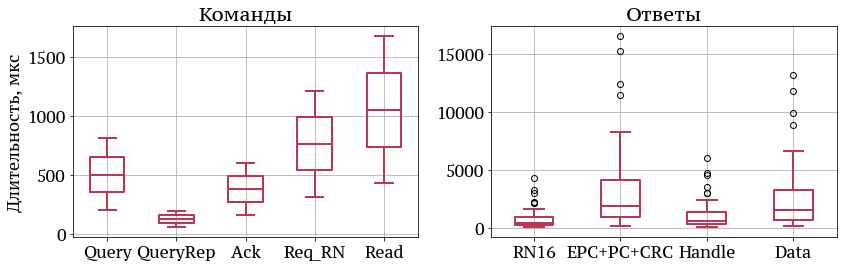

In [186]:
def plot_boxes_for_all_messages(out: Union[str, Sequence[str]] = ()):
    fig, (ax0, ax1) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
    
    props = {'linewidth': 2, 'color': get_color(0.5)}
    
    DF.boxplot(['Query', 'QueryRep', 'Ack', 'Req_RN', 'Read'], ax=ax0, 
               boxprops=props, whiskerprops=props, capprops=props, meanprops=props,
               medianprops=props)
    DF.boxplot(['RN16', 'EPC+PC+CRC', 'Handle', 'Data'], ax=ax1, 
               boxprops=props, whiskerprops=props, capprops=props, meanprops=props,
               medianprops=props)
    
    # for ax in (ax0, ax1):
    #     for tick in ax.get_xticklabels():
    #         tick.set_rotation(45)
    
    set_axes_formatter(ax0, ax1, use_y=True)
    ax0.set_ylabel("Длительность, мкс")
    ax0.set_title("Команды")
    ax1.set_title("Ответы")
    

#     DF['query'].hist(bins=100, ax=axes[0][0])
#     axes[0][0].set_xlabel("Длительность, мкс")
#     axes[0][0].set_title("Query")

#     DF.boxplot('query', by='tari', ax=axes[0][1])
#     DF.boxplot('epc', by='tari', ax=axes[0][2])
#     DF['epc'].hist(ax=axes[1][0])
    
    plt.tight_layout()
    savefig(out)

plot_boxes_for_all_messages(out=("ch2_messages_durations.pdf", "ch2_messages_durations.png"))

Можно заметить, что разброс длительностей команд и ответов очень большой. В некоторых случаях,
длительности могут различаться в 10 и более раз, в зависимости от параметров канала.

Рассмотрим внимательнее, как зависят длительности от тех или иных параметров.

Во-первых, рассмотрим влияние `Tari`.

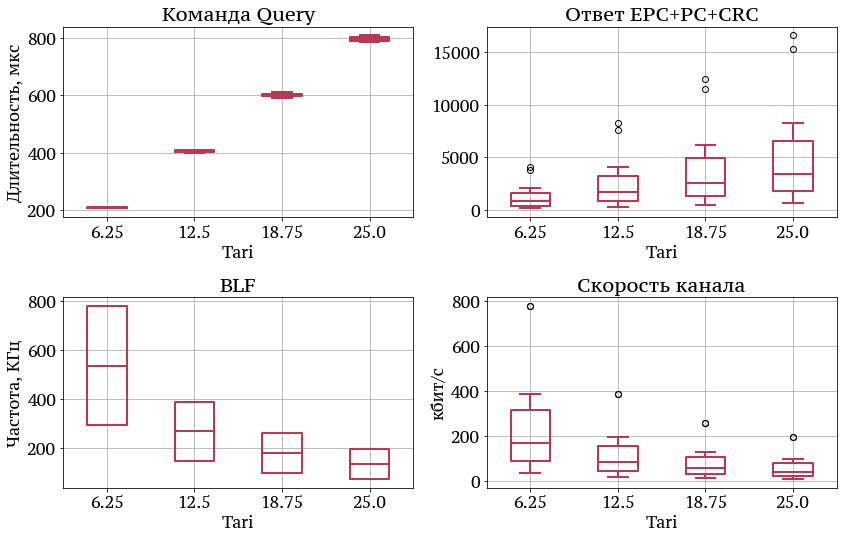

In [187]:
def plot_boxes_of_tari(out: Union[str, Sequence[str]] = ()):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
    
    props = {'linewidth': 2, 'color': get_color(0.5)}
    
    DF.boxplot('Query', by='Tari', ax=ax0, 
               boxprops=props, whiskerprops=props, capprops=props, meanprops=props,
               medianprops=props)
    DF.boxplot('EPC+PC+CRC', by='Tari', ax=ax1, 
               boxprops=props, whiskerprops=props, capprops=props, meanprops=props,
               medianprops=props)
    DF.boxplot('BLF', by='Tari', ax=ax2, 
               boxprops=props, whiskerprops=props, capprops=props, meanprops=props,
               medianprops=props)
    DF.boxplot('Bitrate', by='Tari', ax=ax3, 
               boxprops=props, whiskerprops=props, capprops=props, meanprops=props,
               medianprops=props)
    
    set_axes_formatter(ax0, ax1, ax2, ax3, use_y=True)

    ax0.set_ylabel("Длительность, мкс")
    ax2.set_ylabel("Частота, КГц")
    ax3.set_ylabel("кбит/с")
    
    ax0.set_title("Команда Query")
    ax1.set_title("Ответ EPC+PC+CRC")
    ax3.set_title("Скорость канала")
    
    fig.suptitle("")
    
    plt.tight_layout()
    savefig(out)


plot_boxes_of_tari()

Посмотрим более подробно на длительности ответов.

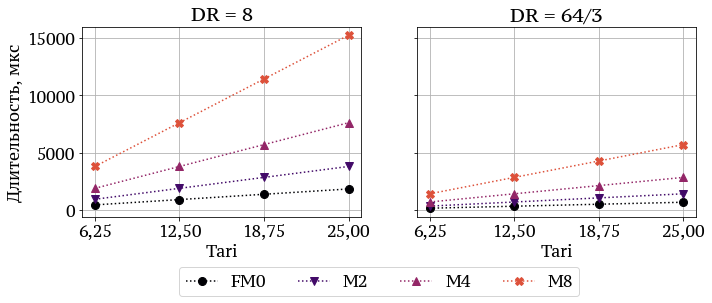

In [219]:
def plot_t2r_props(out: Union[str, Sequence[str]] = ()):
    fig, (ax0, ax1) = plt.subplots(figsize=(11, 3.5), nrows=1, ncols=2, sharey=True)
    
    markers = ["o", "v", "^", "X"]
    df = DF[DF.TRext == False][["Tari", "M", "DR", "EPC+PC+CRC", "BLF"]]
    df0 = df[df.DR == DR.DR_8]
    df1 = df[df.DR == DR.DR_643]
        
    for i, m in enumerate(M):
        y0 = [df0[(df0.Tari == t) & (df0.M == m)]['EPC+PC+CRC'] for t in TARI_US]
        y1 = [df1[(df1.Tari == t) & (df1.M == m)]['EPC+PC+CRC'] for t in TARI_US]
        c = get_color(i / len(M) * 0.8)
        ax0.plot(TARI_US, y0, linestyle=':', marker=markers[i], markersize=8,
                 label=f"{m.name}", color=c)
        ax1.plot(TARI_US, y1, linestyle=':', marker=markers[i], markersize=8,
                 label=f"{m.name}", color=c)
    
    for ax in (ax0, ax1):
        ax.set_xticks(TARI_US)
        ax.set_xlabel("Tari")
        ax.grid()
    
    ax0.set_ylabel("Длительность, мкс") 
    ax0.set_title("DR = 8")
    ax1.set_title("DR = 64/3")
        
    set_axes_formatter(ax0, ax1, use_y=True)
    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', 
               bbox_to_anchor=(0.5, -0.22), ncol=4)
    savefig(out)

plot_t2r_props(out=("ch2_response_durations.pdf", "ch2_response_durations.png"))

## Вычисление длительности раунда с одной меткой

В следующих расчетах будем исходить из предположения, что в раунде участвует одна метка.
В общем случае это предположение, конечно, не выполняется, но для системы идентификации
автомобилей оно имеет смысл - из-за геометрии автомобилей и малой длины области чтения
вероятность попадания двух и более меток в зону действия считывателя одновременно мала.

Более детально зависимость длительности раунда от числа меток будет исследоваться в другой
главе диссертации, при построении аналитической модели RFID.